In [42]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr


In [43]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("dataset.tsv", sep='\t', header=None, names = column)
df.describe()


,objID,z,uMAG,rMAG,u-r,SVMPython
count,3.160310e+05,316031.000000,316031.000000,316031.000000,316031.000000,316031.000000
mean,1.237662e+18,0.063504,-18.495233,-20.575399,2.080166,0.558053
std,6.022167e+12,0.023058,1.034802,1.140994,0.610873,0.496619
min,1.237646e+18,0.003001,-26.045010,-25.957740,-3.803460,0.000000
25%,1.237658e+18,0.045979,-19.147785,-21.304710,1.660000,0.000000
50%,1.237662e+18,0.067202,-18.601710,-20.713750,2.158930,1.000000
75%,1.237665e+18,0.082217,-18.002450,-20.047520,2.500980,1.000000
max,1.237680e+18,0.100000,54.116670,-13.083160,78.125900,1.000000


In [44]:
# Selecting only 0.05 < z < 0.08 and spiral (late-type!) (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50) & (df['rMAG']>-22)]
print("Dataframe size post-cut:",df.size)
df = df.sample(n=10000)

Dataframe size post-cut: 413856


In [45]:
max(df['uMAG'])

-10.514

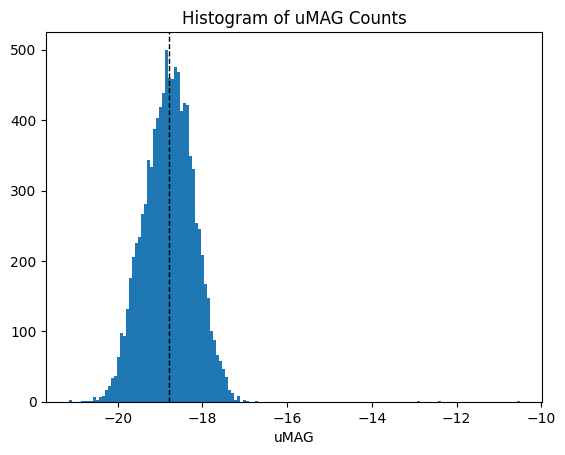

-19.563458999999998 -18.045246


In [46]:

plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")
plt.show()
print(np.percentile(df['uMAG'],10),np.percentile(df['uMAG'],90)) # Find the censor range for later

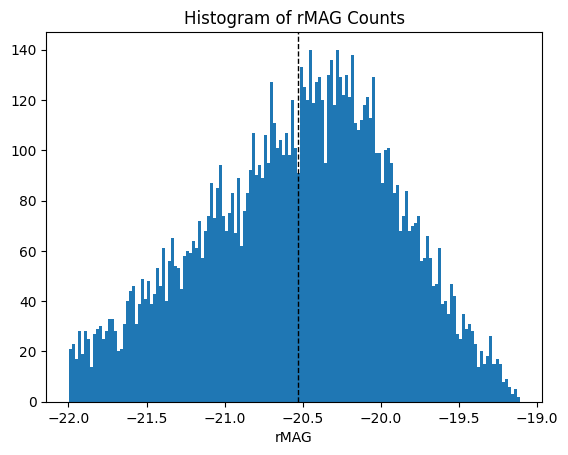

In [47]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")
plt.show()

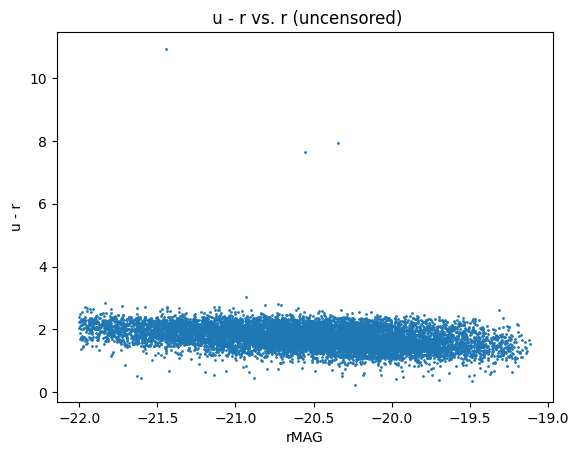

In [48]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title(" u - r vs. r (uncensored)")
plt.show()

In [49]:
# Adding censored data column for -19.5 < uMAG < -18.1
print(len(df[df["uMAG"]>-18]))
df['censored_uMAG'] = df['uMAG'].clip(upper=-18,lower=-19.5) # Made the censoring code a little prettier
censored_array=np.array([])
for i in np.array(df["uMAG"]): # This code is ugly - does pandas have a way to do this itself?
    if (i<-18 and i>-19.5):
        censored_array=np.append(censored_array,False)
    else:
        censored_array=np.append(censored_array,True)
df['censored']=censored_array
df.head()
#df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17 (Old code)

865


,objID,z,uMAG,rMAG,u-r,SVMPython,censored_uMAG,censored
11957,1237663782602539149,0.071581,-19.16543,-21.21399,2.04856,1,-19.16543,0.0
658,1237663784198340746,0.057576,-18.05993,-19.71555,1.65562,1,-18.05993,0.0
161138,1237664291540697356,0.071941,-18.79339,-20.82239,2.02900,1,-18.79339,0.0
116124,1237662195058540614,0.076003,-18.99245,-20.66572,1.67328,1,-18.99245,0.0
287171,1237659154217697592,0.074032,-19.58663,-21.90695,2.32032,1,-19.50000,1.0


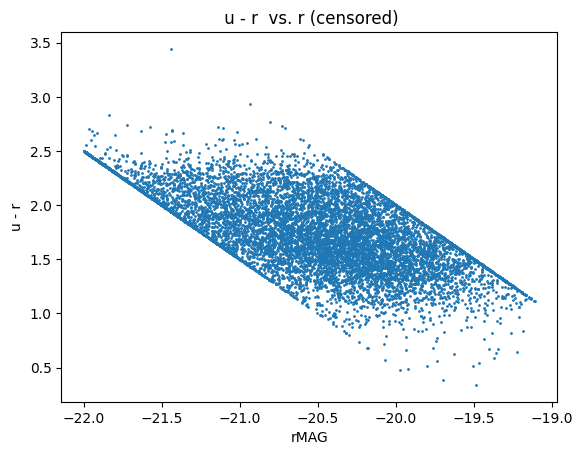

In [50]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title(" u - r  vs. r (censored)")
plt.show()

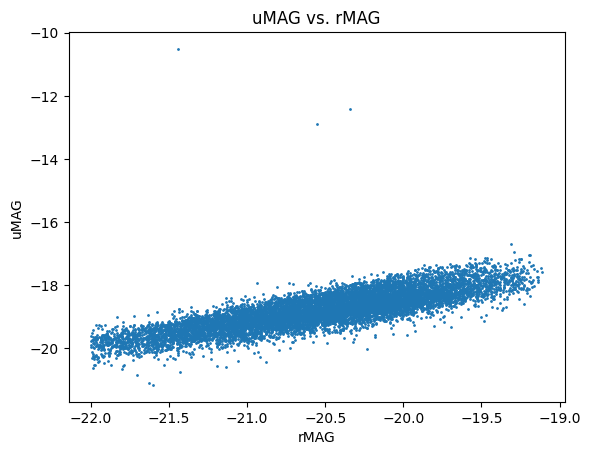

In [51]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG')
plt.show()

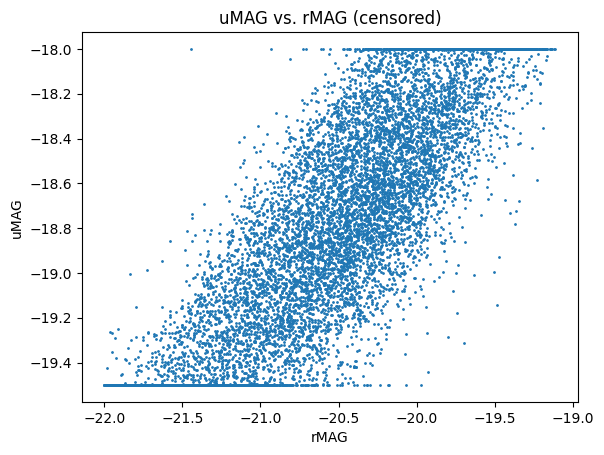

In [52]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')
plt.show()

# `u-r vs r (uncensored)`

In [53]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=sigma, observed=y)

    return model

In [55]:
q1_model = lregression(df['rMAG'], df['u-r'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = 5000)

AssertionError: 

AssertionError: 

array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

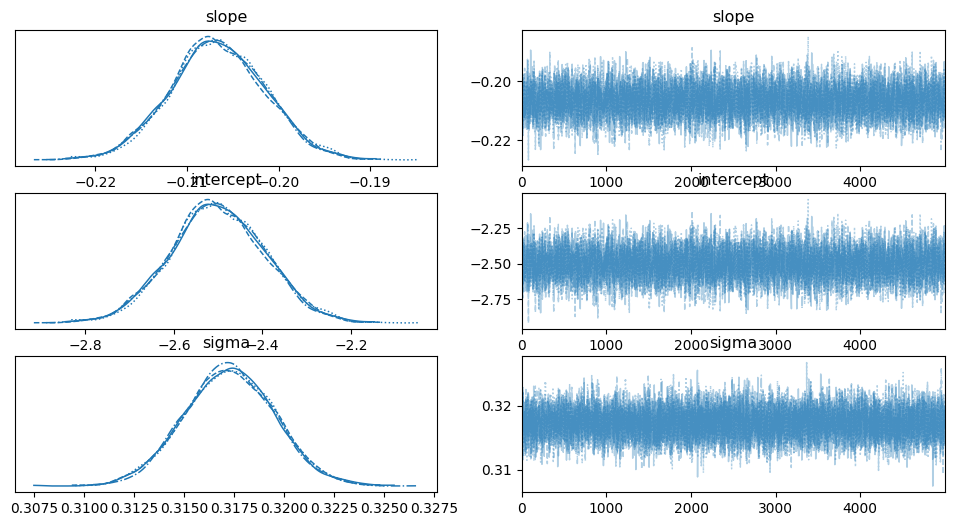

In [ ]:
az.plot_trace(q1_fit)

In [ ]:
summ=az.summary(q1_fit)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.207,0.005,-0.216,-0.197,0.000,0.000,6004.0,6693.0,1.0
intercept,-2.501,0.106,-2.705,-2.307,0.001,0.001,6012.0,6630.0,1.0
sigma,0.317,0.002,0.313,0.321,0.000,0.000,8690.0,8280.0,1.0


[Text(0.5, 1.0, 'u-r vs r (uncensored data) fit'), None]

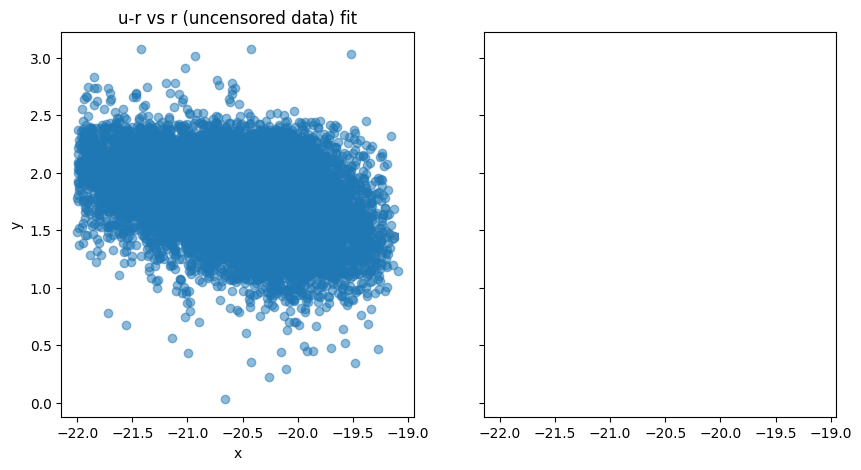

In [ ]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="steelblue", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['u-r'], q1_fit, ax[0],true=True)
ax[0].set(title="u-r vs r (uncensored data) fit",alpha=0.5)

# `u-r vs r (censored)`

In [ ]:
def censored_regression(x, y):
    with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)

        start = pm.find_MAP()
        step = pm.NUTS()
    return model

NameError: name 'model' is not defined

In [ ]:
censored_model = censored_regression(df['rMAG'], df['u-r'])

with censored_model:
    censored_fit = pm.sample(5000, init="adapt_diag", step=pm.NUTS())

/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_54493/2288469712.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_54493/2288469712.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


AssertionError: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(censored_fit, var_names=["slope"], ref_val=slope, ax=ax[1])
ax[1].set(title="Censored regression\n(censored data)", xlabel="slope");

